# Data augmentation

Data augmentation is when we modify our images and masks when we load them from files using the dataset object. This process is stochastic, so the images loaded in each training epoch differ slightly.

The main reason one uses data augmentation is to augment the generalization of our model to new images. By changing the images in each training epoch, we force the model to learn more generalizable features instead of learning specific features unique to each labeled image.

With data augmentation, you don't need to label as many images as without data augmentation.

I used the [Albumentations](https://albumentations.ai/) library to implement data augmentation. One can create a pipeline to process our images when they are loaded from files. The library can work with image-mask pairs used for segmentation.

The normalization of our images (set mean and std of each channel to 0 and 1) can also be performed by the data augmentation pipeline. See the notebook on data normalization.

Below, I am using four transformations. We can set the probability that this transformation is applied using the `p` argument. You can set it in the project configuration file. Alternatively, you can edit the code below.

### Tips

* If you track left/right body parts, you probably don't want to flip your images. This would mean setting 'augmentation_HorizontalFlipProb': 0.0 in your `config.yalm` file.


In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:
      Successfully uninstalled albumentations-1.3.1
Cloning into 'unetTracker'...
remote: Enumerating objects: 965, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 965 (delta 207), reused 327 (delta 196), pack-reused 621
Receiving objects: 100% (965/965), 124.39 MiB | 34.44 MiB/s, done.
Resolving deltas: 100% (597/597), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 8.3

Obtaining file:///content/unetTracker
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for unetTracker (pyproject.toml) ... done
  Created wheel for unetTracker: filename=unetTracker-0.0.1-0.editable-py3-none-any.whl size=16048 sha256=a6f068b986e8d2009cb03a4559965316854dde359b86cb717d0d0d645bf7113c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jvq3p796/wheels/62/9b/5a/0cb547490a9187d698861d98e1e803c5e64f31a9d899a8e84c
Successfully built unetTracker


In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/dsfolder"
if os.path.exists(fn):
  print("We can access the dsfolder directory.")
else:
  raise IOError("Problem accessing the dsfolder directory.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
We can access the dsfolder directory.


In [2]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/dsfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/dsfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'finger_tracker', 'normalization_values': {'means': [0.40664952993392944, 0.4527093172073364, 0.5142642259597778], 'stds': [0.2394399791955948, 0.2509937286376953, 0.26815035939216614]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['f1', 'f2', 'f3', 'f4'], 'target_radius': 6, 'unet_features': [64, 128, 256, 512]}


In [3]:
import albumentations as A
from unetTracker.dataset import UNetDataset

In [4]:
original_height = project.image_size[0]
original_width = project.image_size[1]
means = project.normalization_values["means"]
stds = project.normalization_values["stds"]

trainTransform = A.Compose([
                    A.RandomSizedCrop(min_max_height=(original_height-50, original_height),
                                      w2h_ratio=original_width/original_height,height=original_height, width=original_width,
                                      p=project.augmentation_RandomSizedCropProb),
                    A.HorizontalFlip(p=project.augmentation_HorizontalFlipProb),
                    A.Rotate (limit=30,border_mode=cv2.BORDER_CONSTANT,p=project.augmentation_RotateProb),

                    A.Normalize(mean=means, std=stds)
])

valTransform = A.Compose([
                    A.Normalize(mean=means, std=stds)
])


print(trainTransform)
print(valTransform)

Compose([
  RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(220, 270), height=270, width=480, w2h_ratio=1.7777777777777777, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  Rotate(always_apply=False, p=0.3, limit=(-30, 30), interpolation=1, border_mode=0, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
  Normalize(always_apply=False, p=1.0, mean=[0.40664952993392944, 0.4527093172073364, 0.5142642259597778], std=[0.2394399791955948, 0.2509937286376953, 0.26815035939216614], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.40664952993392944, 0.4527093172073364, 0.5142642259597778], std=[0.2394399791955948, 0.2509937286376953, 0.26815035939216614], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


We don't want to apply data augmentation on the validation set.

We can save the transformation in a `augmentation` directory inside our project directory.

We will be able to load the data augmentation pipeline from files when training the model.

In [5]:
project.augmentation_dir
if os.path.exists(project.augmentation_dir) == False:
    os.mkdir(project.augmentation_dir)

In [6]:
fileName = os.path.join(project.augmentation_dir,"trainTransform")
print("Saving trainTransform as", fileName)
pickle.dump( trainTransform, open( fileName, "wb" ))


Saving trainTransform as /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/augmentation/trainTransform


In [7]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Saving trainTransform as", fileName)
pickle.dump( valTransform, open( fileName, "wb" ))


Saving trainTransform as /content/drive/My Drive/dsfolder/trackingProjects/finger_tracker/augmentation/valTransform


## Visualize the effect of data augmentation

We can create two datasets pointing to the same directory. Only one dataset will perform data augmentation. We can then compare the image with and without data augmentation.

In [8]:
train_image_dir = os.path.join(project.dataset_dir,"train_images")
train_mask_dir =  os.path.join(project.dataset_dir,"train_masks")
train_coordinate_dir = os.path.join(project.dataset_dir,"train_coordinates")
dataset_noAugmentation = UNetDataset(image_dir=train_image_dir,
                           mask_dir=train_mask_dir,
                           coordinate_dir=train_coordinate_dir,
                           transform=valTransform, # we pass our transform function to the UNetDataset object
                           image_extension=project.image_extension)
dataset_withAugmentation = UNetDataset(image_dir=train_image_dir,
                           mask_dir=train_mask_dir,
                           coordinate_dir=train_coordinate_dir,
                           transform=trainTransform, # we pass our transform function to the UNetDataset object
                           image_extension=project.image_extension)

In [9]:
imageNoAugmentation, _, _ = dataset_noAugmentation[0]
imageWithAugmentation, _, _ = dataset_withAugmentation[0]

In [10]:
imageNoAugmentation.mean(),imageWithAugmentation.mean()

(tensor(-0.0361), tensor(-0.1193))

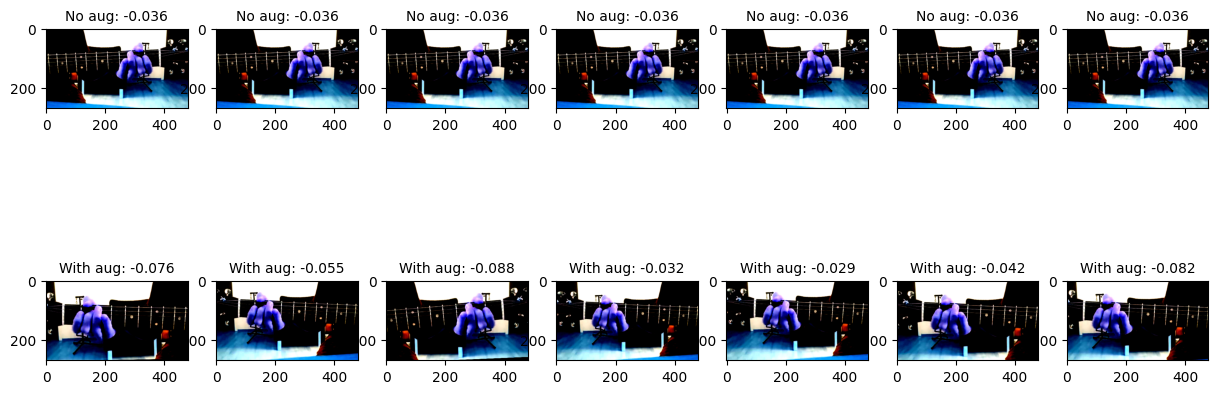

In [11]:
fig, axs = plt.subplots(2, 7,figsize=(15,6))
for i in range(7):
    imageNoAugmentation, _, _ = dataset_noAugmentation[0]
    imageWithAugmentation, _, _ = dataset_withAugmentation[0]
    axs[0,i].imshow(imageNoAugmentation.permute(1,2,0))
    axs[0,i].set_title("No aug: {:.3f}".format(imageNoAugmentation.mean().item()),fontsize=10)
    axs[1,i].imshow(imageWithAugmentation.permute(1,2,0))
    axs[1,i].set_title("With aug: {:.3f}".format(imageWithAugmentation.mean().item()),fontsize=10)